In [11]:
import cv2
import os
import numpy as np
from PIL import Image # Mozno viac safe to use ako cv2
from pathlib import Path
from albumentations import Compose, HorizontalFlip, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur

In [ ]:
def rename_images_in_folders(base_path):
    folder_path = base_path / 'train'
    
    if not folder_path.exists():
        print("Train folder not found!")
        return
    
    # Process folders 1-31
    for folder_num in range(1, 32):
        subfolder = folder_path / str(folder_num)
        
        if not subfolder.exists():
            continue
            
        image_files = sorted(subfolder.glob('*.png'))
        
        if not image_files:
            continue
            
        print(f"Folder {folder_num}: Renaming {len(image_files)} images")
        for i, img_path in enumerate(image_files, start=1):
            try:
                # Create new filename
                new_name = f"{folder_num}_{i}.png"
                new_path = subfolder / new_name
                
                # Rename the file
                os.rename(img_path, new_path)
                
            except Exception as e:
                print(f"Error renaming {img_path}: {str(e)}")

directory = Path('.')
rename_images_in_folders(directory)

In [5]:
# For other cells needs to remove wav files!
def remove_non_png_files(base_path):
    folder_path = base_path / 'train'
    #folder_path = base_path / 'dev'
    
    if not folder_path.exists():
        return
    
    # Process folders 1-31
    for folder_num in range(1, 32):
        subfolder = folder_path / str(folder_num)
        
        if not subfolder.exists():
            continue
            
        # Get all files (not just PNGs)
        all_files = list(subfolder.glob('*'))
        png_files = list(subfolder.glob('*.png'))
        non_png_files = [f for f in all_files if f not in png_files]
        
        if not non_png_files:
            continue
            
        print(f"Folder {folder_num}: Found {len(non_png_files)} non-PNG files")
        for file_path in non_png_files:
            try:
                # Delete the file
                os.remove(file_path)
            except Exception as e:
                print(f"Error removing {file_path}: {str(e)}")

# Usage
directory = Path('.')  # Current directory or specify your path
remove_non_png_files(directory)

Folder 1: Found 6 non-PNG files
Folder 2: Found 6 non-PNG files
Folder 3: Found 6 non-PNG files
Folder 4: Found 6 non-PNG files
Folder 5: Found 6 non-PNG files
Folder 6: Found 6 non-PNG files
Folder 7: Found 6 non-PNG files
Folder 8: Found 6 non-PNG files
Folder 9: Found 6 non-PNG files
Folder 10: Found 6 non-PNG files
Folder 11: Found 6 non-PNG files
Folder 12: Found 6 non-PNG files
Folder 13: Found 6 non-PNG files
Folder 14: Found 6 non-PNG files
Folder 15: Found 6 non-PNG files
Folder 16: Found 6 non-PNG files
Folder 17: Found 6 non-PNG files
Folder 18: Found 6 non-PNG files
Folder 19: Found 6 non-PNG files
Folder 20: Found 6 non-PNG files
Folder 21: Found 6 non-PNG files
Folder 22: Found 6 non-PNG files
Folder 23: Found 6 non-PNG files
Folder 24: Found 6 non-PNG files
Folder 25: Found 6 non-PNG files
Folder 26: Found 6 non-PNG files
Folder 27: Found 6 non-PNG files
Folder 28: Found 6 non-PNG files
Folder 29: Found 6 non-PNG files
Folder 30: Found 6 non-PNG files
Folder 31: Found 6 

In [5]:
# Setup paths
folder_path = './train'

# Create 3 augmented versions per image
n_augments = 1 

def flip_horizontal(image):
    """More subtle darkening with optional flip"""
    img_array = np.array(image)
    img_array = np.fliplr(img_array)
    return Image.fromarray(img_array)

for class_dir in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_dir)
    if not os.path.isdir(class_path):
        continue
        
    os.makedirs(f"{folder_path}/{class_dir}", exist_ok=True)
    
    for img_file in os.listdir(class_path):
        file_path = os.path.join(class_path, img_file)
        
        try:
            img = Image.open(file_path)
            pil_img = flip_horizontal(img)
            pil_img.save(f"{folder_path}/{class_dir}/{Path(img_file).stem}_flip.jpg")
                
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            continue

print("Flip complete!")

Flip complete!


In [15]:
def gaussian_noise(image, mean=0, std_range=(1, 4)):  # Reduced noise
    """Minimal Gaussian noise"""
    std = np.random.uniform(*std_range)
    img_array = np.array(image).astype(np.float32)
    noise = np.random.normal(mean, std, img_array.shape)
    return Image.fromarray(np.clip(img_array + noise, 0, 255).astype(np.uint8))

def darken_img(image, darken_range=(0.90, 0.95)):  # More subtle darkening
    """Minimal brightness reduction"""
    factor = np.random.uniform(*darken_range)
    img_array = np.array(image)
    return Image.fromarray(np.clip(img_array * factor, 0, 255).astype(np.uint8))

for class_dir in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_dir)
    if not os.path.isdir(class_path):
        continue
        
    for img_file in os.listdir(class_path):
        file_path = os.path.join(class_path, img_file)
        
        try:
            img = Image.open(file_path).convert('RGB')
            
            # Create 2 subtle variants
            for i in range(1, n_augments + 1):
                # Start with original
                augmented = np.array(img.copy())
                
                # Convert back to PIL
                pil_img = Image.fromarray(augmented)
                
                # Apply ONE custom augmentation per variant
                if i == 1:
                    pil_img = gaussian_noise(pil_img)
                else:
                    pil_img = darken_img(pil_img)
                
                # Save with original filename + augmentation ID
                pil_img.save(f"{class_path}/{Path(img_file).stem}_{i}.jpg")
                
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            continue

print("Augmentation complete!")

Augmentation complete!


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.set_num_threads(8)  # Match CPU core count
torch.backends.openmp.enabled = True  # Enable OpenMP

class FaceCNN(nn.Module):
    def __init__(self, num_classes=31):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 512),
            nn.ReLU(),
            nn.Dropout(0.3),  # Reduced from 0.7
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [21]:
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create full dataset - USE train_transform HERE
full_dataset = datasets.ImageFolder('./train', transform=train_transform)

# Verify class count
assert len(full_dataset.classes) == 31, f"Expected 31 classes, got {len(full_dataset.classes)}"

# Split indices - get last 2 samples per class
val_indices = []
train_indices = []

for class_idx in range(len(full_dataset.classes)):
    # Get all indices for current class
    class_indices = np.where(np.array(full_dataset.targets) == class_idx)[0]
    
    # Ensure we have enough samples (at least 3 per class)
    if len(class_indices) < 3:
        raise ValueError(f"Class {class_idx} has only {len(class_indices)} samples (need at least 3)")
    
    # Last 2 samples for validation
    val_indices.extend(class_indices[-2:])
    # Rest for training
    train_indices.extend(class_indices[:-2])

# Create subsets
train_data = Subset(full_dataset, train_indices)
val_data = Subset(full_dataset, val_indices)

# Create DataLoaders
train_loader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_data,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

Training samples: 682
Validation samples: 62


In [22]:
print(f"PyTorch using: {torch.get_num_threads()} CPU threads")
print(f"Optimization backend: {torch.backends.quantized.engine}")

PyTorch using: 8 CPU threads
Optimization backend: x86


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FaceCNN(num_classes=31).to(device)

# Improved optimizer setup
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, 
                            weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# Add label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def train(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Add gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            
            optimizer.step()
            running_loss += loss.item()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        scheduler.step(val_acc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | '
              f'Val Acc: {val_acc:.2f}% | Best Acc: {best_acc:.2f}%')

In [24]:
# Start training
train(epochs=50)

Epoch 1/50 | Loss: 3.0447 | Val Acc: 32.26% | Best Acc: 32.26%
Epoch 2/50 | Loss: 2.0605 | Val Acc: 56.45% | Best Acc: 56.45%
Epoch 3/50 | Loss: 1.5506 | Val Acc: 72.58% | Best Acc: 72.58%
Epoch 4/50 | Loss: 1.2341 | Val Acc: 85.48% | Best Acc: 85.48%
Epoch 5/50 | Loss: 1.0715 | Val Acc: 93.55% | Best Acc: 93.55%
Epoch 6/50 | Loss: 0.9499 | Val Acc: 96.77% | Best Acc: 96.77%
Epoch 7/50 | Loss: 0.8788 | Val Acc: 100.00% | Best Acc: 100.00%
Epoch 8/50 | Loss: 0.8447 | Val Acc: 100.00% | Best Acc: 100.00%
Epoch 9/50 | Loss: 0.8276 | Val Acc: 100.00% | Best Acc: 100.00%
Epoch 10/50 | Loss: 0.7998 | Val Acc: 100.00% | Best Acc: 100.00%


KeyboardInterrupt: 

In [25]:
model = FaceCNN(num_classes=31).to(device)
model.load_state_dict(torch.load('best_model.pth'))  # Load saved weights
model.eval()  # Set to evaluation mode

C:\Users\adamk\AppData\Local\Temp\ipykernel_5540\2982555762.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))  # Load s

FaceCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=31, bias=Tr

In [26]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Assuming test images are in './test' with same class folders
test_dataset = datasets.ImageFolder('./dev', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=62, shuffle=False)

In [27]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    # Return for further analysis
    return all_preds, all_labels, accuracy

In [28]:
# Get predictions
predictions, true_labels, test_acc = evaluate(model, test_loader)

# Additional metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset.classes))

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predictions))

Test Accuracy: 58.06%

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
          10       1.00      1.00      1.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       1.00      1.00      1.00         2
          15       0.67      1.00      0.80         2
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         2
          18       0.50      0.50      0.50         2
          19       1.00      1.00      1.00         2
           2       0.00      0.00      0.00         2
          20       0.00      0.00      0.00         2
          21       1.00      1.00      1.00         2
          22       0.40      1.00      0.57         2
          23       1.00      0.50      0.67         2
          24       1.00      1.00  

D:\VUT\Anaconda\envs\SUR\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\VUT\Anaconda\envs\SUR\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\VUT\Anaconda\envs\SUR\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


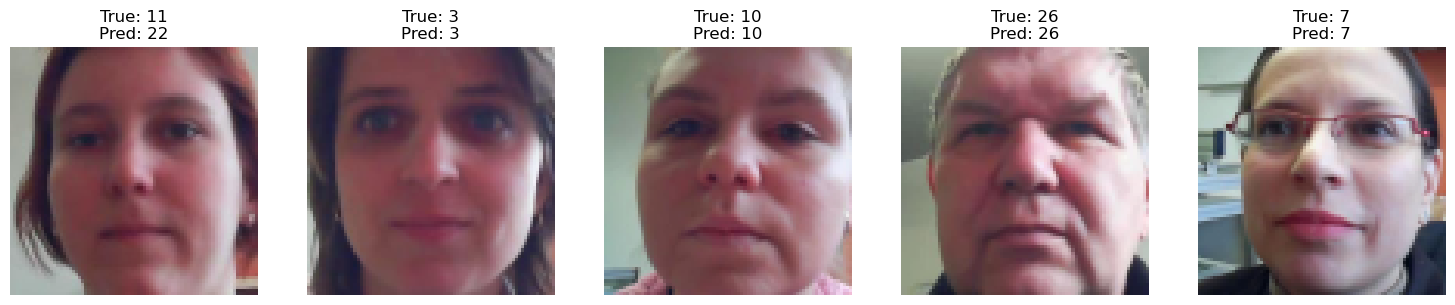

In [29]:
import matplotlib.pyplot as plt

def show_test_samples(model, dataset, num_samples=5):
    indices = torch.randperm(len(dataset))[:num_samples]
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for idx, ax in zip(indices, axes):
        image, label = dataset[idx]
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
            _, pred = torch.max(output, 1)
        
        # Denormalize for display
        img = image.squeeze().cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f'True: {dataset.classes[label]}\nPred: {dataset.classes[pred.item()]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_test_samples(model, test_dataset)